<h2 id="t1" style="margin-bottom: 18px">Imbalanced datasets</h2>


Class 0: 573518
Class 1: 21694
Proportion of class 0 is  96.36 %


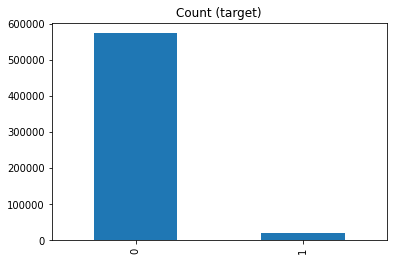

In [ ]:
import numpy as np
import pandas as pd

df_train = pd.read_csv('train.csv')
df_train

target_count = df_train.target.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion of class 0 is ', round(target_count[0] * 100 / (target_count[1] + target_count[0]), 2),'%')

target_count.plot(kind='bar', title='Count (target)');

<h2 id="t2" style="margin-bottom: 18px">The metric trap</h2>

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Remove 'id' and 'target' columns
labels = df_train.columns[2:]
df_train = df_train.dropna()

X = df_train[labels]
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 7)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

KeyboardInterrupt: ignored

Now let's run the same code, but using only one feature (which should drastically reduce the accuracy of the classifier):

In [ ]:
model = XGBClassifier()
model.fit(X_train[['ps_ind_04_cat']], y_train)
y_pred = model.predict(X_test[['ps_ind_04_cat']])

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.29%


<h2 id="t3" style="margin-bottom: 18px">Confusion matrix</h2>


Confusion matrix:
 [[32247     0]
 [ 1242     0]]


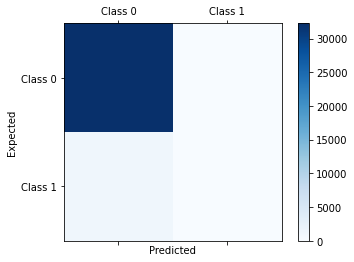

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.6263623733397274

# Sampling Weights

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
clf.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=0)

In [ ]:
print("Accuracy : ", clf.score(X_test,y_test) * 100, "%")

Accuracy :  96.22043081802563 %


In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score
confusion_matrix(y_test, clf.predict(X_test))
roc_auc_score(y_test, clf.decision_function(X_test))

0.6056593530841574

In [ ]:
clf = LogisticRegression(class_weight = {0:5,1:95})
clf.fit(X_train,y_train)
print("Accuracy : ", clf.score(X_test,y_test) * 100, "%")
confusion_matrix(y_test, clf.predict(X_test))
roc_auc_score(y_test, clf.decision_function(X_test))

Accuracy :  81.73648737941059 %


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.6146244757699229

<h2 id="t4" style="margin-bottom: 18px">Resampling</h2>


![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png)

In [ ]:
# Class count
count_class_0, count_class_1 = df_train.target.value_counts()

# Divide by class
df_class_0 = df_train[df_train['target'] == 0]
df_class_1 = df_train[df_train['target'] == 1]

count_class_0, count_class_1


(109331, 4173)

<h2 id="t5">Random under-sampling</h2>

In [ ]:
count_class_1, count_class_0

(3388, 88544)

Random under-sampling:
0    4173
1    4173
Name: target, dtype: int64


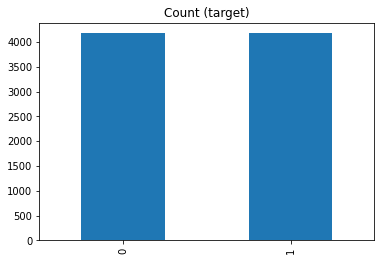

In [ ]:
df_class_0_under = df_class_0.sample(count_class_1) #it will randomly sample count_class_1 number of rows from the dataframe
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.target.value_counts())

df_test_under.target.value_counts().plot(kind='bar', title='Count (target)');

<h2 id="t6">Random over-sampling</h2>

Random over-sampling:
0    109331
1    109331
Name: target, dtype: int64


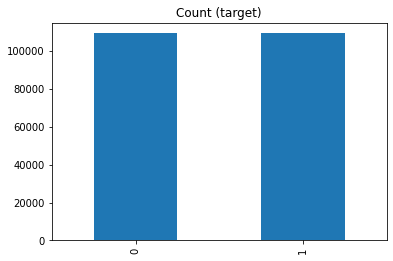

In [ ]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.target.value_counts())

df_test_over.target.value_counts().plot(kind='bar', title='Count (target)');

<h2 id="t7" style="margin-bottom: 18px">Python imbalanced-learn module</h2>

A number of more sophisticated resapling techniques have been proposed in the scientific literature.

For example, we can cluster the records of the majority class, and do the under-sampling by removing records from each cluster, thus seeking to preserve information. In over-sampling, instead of creating exact copies of the minority class records, we can introduce small variations into those copies, creating more diverse synthetic samples.

Let's apply some of these resampling techniques, using the Python library [imbalanced-learn](http://contrib.scikit-learn.org/imbalanced-learn/stable/). It is compatible with scikit-learn and is part of scikit-learn-contrib projects.

In [ ]:
!pip install imblearn

In [ ]:
import imblearn

For ease of visualization, let's create a small unbalanced sample dataset using the <code>make_classification</code> method:

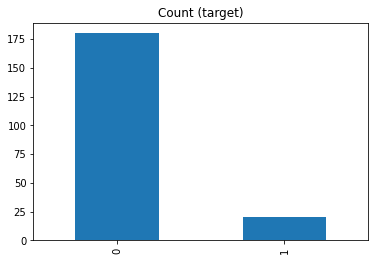

In [ ]:
from sklearn.datasets import make_classification #subpackage used for creating own classifcation dataset
import pandas as pd

X, y = make_classification(
    n_classes=2, class_sep=0.75, weights=[0.9, 0.1],
    n_informative=2, n_redundant=0, flip_y=0,
    n_features=2, n_clusters_per_class=2,
    n_samples=200, random_state=10
)

df = pd.DataFrame(X)
df['target'] = y
#df
df.target.value_counts().plot(kind='bar', title='Count (target)');

We will also create a 2-dimensional plot function, <code>plot_2d_space</code>, to see the data distribution:

In [ ]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

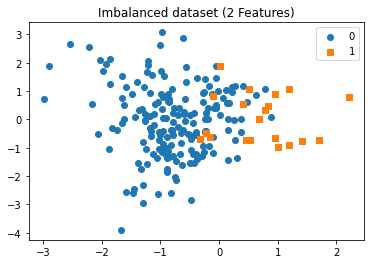

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plot_2d_space(X, y, 'Imbalanced dataset (2 Features)')

<h2 id="#t72">Random under-sampling and over-sampling with imbalanced-learn</h2>

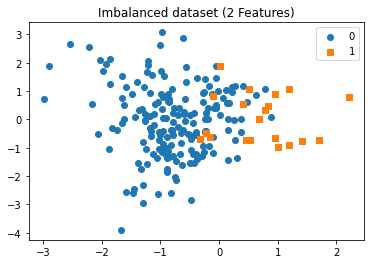

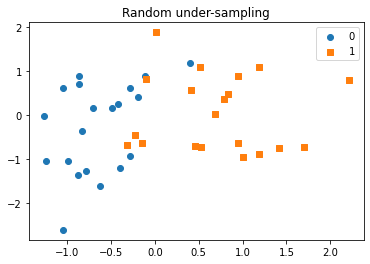

In [ ]:
from imblearn.under_sampling import RandomUnderSampler #  import 

rus = RandomUnderSampler() #Intialise the model
X_rus, y_rus = rus.fit_resample(X, y) #resampling the data 

#print('Removed indexes:', id_rus)

plot_2d_space(X, y, 'Imbalanced dataset (2 Features)')
plot_2d_space(X_rus, y_rus, 'Random under-sampling')

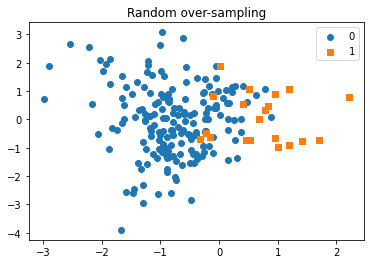

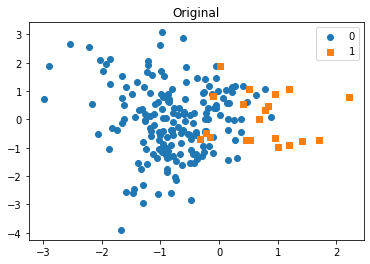

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler() #Initialis the model 
X_ros, y_ros = ros.fit_resample(X, y) #Fit the model

#print(X_ros.shape[0] - X.shape[0], 'new random picked points')

plot_2d_space(X_ros, y_ros, 'Random over-sampling')
plot_2d_space(X, y, 'Original')

In [ ]:
y_ros.sum(), y.sum(), y_rus.sum()

(180, 20, 20)

<h2 id="t8" style="margin-bottom: 18px">Under-sampling: Tomek links</h2>

Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/tomek.png?v=2)

In the code below, we'll use <code>ratio='majority'</code> to resample the majority class.

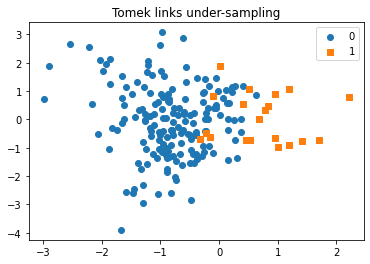

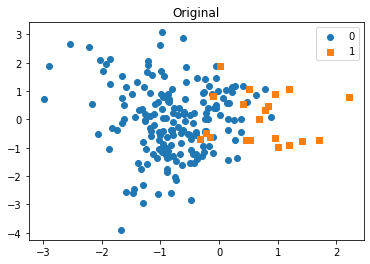

In [ ]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy='majority')
X_tl, y_tl = tl.fit_resample(X, y)

#print('Removed indexes:', id_tl)

plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')
plot_2d_space(X, y, 'Original')

In [ ]:
y.shape, y_tl.shape

((200,), (193,))

<h2 id="t9" style="margin-bottom: 18px">Under-sampling: Cluster Centroids</h2>

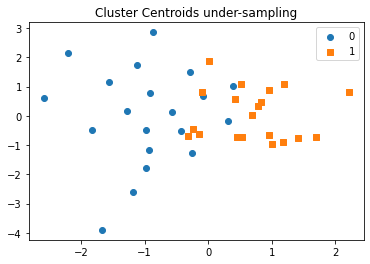

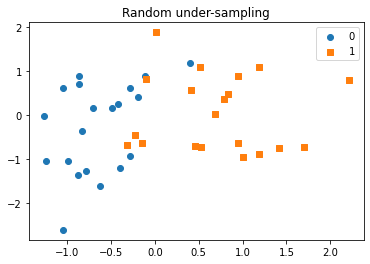

In [ ]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(sampling_strategy={0: 20})
X_cc, y_cc = cc.fit_resample(X, y)

plot_2d_space(X_cc, y_cc, 'Cluster Centroids under-sampling')
#plot_2d_space(X, y, 'Original')
plot_2d_space(X_rus, y_rus, 'Random under-sampling')

In [ ]:
y_cc.sum()/y_cc.shape[0]
#y_cc

<h2 id="t10" style="margin-bottom: 18px">Over-sampling: SMOTE</h2>

SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picingk a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

 ![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/smote.png)

We'll use <code>ratio='minority'</code> to resample the minority class.

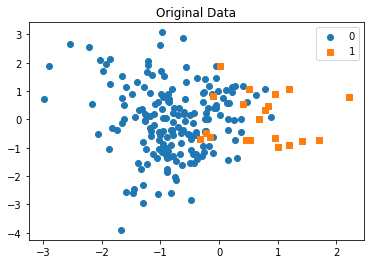

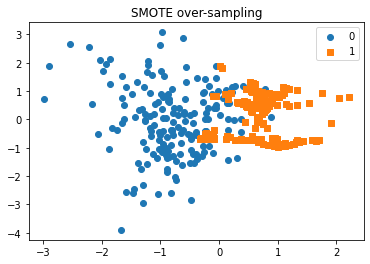

In [ ]:
from imblearn.over_sampling import SMOTE

plot_2d_space(X, y, 'Original Data')

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

<h2 id="t11" style="margin-bottom: 18px">Over-sampling followed by under-sampling</h2>

Now, we will do a combination of over-sampling and under-sampling, using the SMOTE and Tomek links techniques:

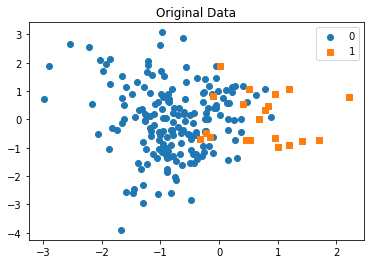

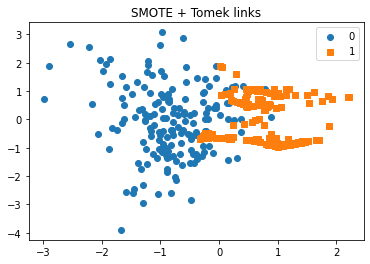

In [ ]:
from imblearn.combine import SMOTETomek

plot_2d_space(X, y, 'Original Data')

smt = SMOTETomek(sampling_strategy='all')
X_smt, y_smt = smt.fit_resample(X, y)

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')

In [ ]:
y_smt.shape

(340,)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lr = LogisticRegression()
lr.fit(X_smt,y_smt)
lr.score(X_smt,y_smt)

print( "AUROC on the sampled dataset : ",roc_auc_score(y, lr.predict_proba(X)[:, 1]))

AUROC on the sampled dataset :  0.951111111111111
